In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop , Adam
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer , Flatten
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

In [16]:
df_btc = pd.read_csv("BTC_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [17]:
btc_data = df_btc.values[:, 4 ,].astype(float)

<Strong> Scaling the data  </Strong>

In [18]:
percTrain = 70
percVal = 20 

In [19]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Hyper-parameters </Strong>

In [20]:
# Hyper Parameters 

# How many hidden layers we should have 
# Learning rate
# Kernel Size
# Window Size
#Filters

window_length = 120
features = 1

<Strong> Creating Matrix in Sliding window form <Strong>

In [21]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data into train , val , test </Strong>

In [22]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

<Strong> The number of layers while changing dilation_base , kernel_size or window_size. </Strong>

In [ ]:
def getLayers(dilation_rate , window_size , kernel_size):
    
    top = (dilation_rate - 1) * (window_size - 1)
    bottom = (kernel_size - 1) 
    
    division = (top / bottom) + 1 
    log = math.ceil(math.log(division , dilation_rate))
    
    
    # This inequality must hold true for full coverage
    
    first = 1 + (kernel_size - 1)
    second = (dilation_rate ** log ) - 1
    third = dilation_rate - 1
    
    inequality = (second / third) * first
    
    if ( (kernel_size < dilation_rate) or (inequality < window_size) ):
        print("not going to have full coverage")
        return False
    
    else:
        print("layers =" , log , "dilation rate =" , dilation_rate , "kernel size =" , kernel_size , )
        return log , dilation_rate , kernel_size

getLayers( 5 , 24 , 3)

<Strong> First 3-Layer Model with <i> dilation_rate = 3 </i> and <i> kernel_size = 3 </i> </Strong>

In [11]:
def createModelThreeLayers(hp):

    hp_learning_rate = hp.Choice('learning_rate' , values = [0.002 , 0.004 , 0.006])
    hp_dense_layer = hp.Choice('dense_layer' , values = [16 , 32 , 64 ])
    hp_filters = hp.Choice ('filters' , values = [8 , 16 , 32])
    hp_dropout = hp.Choice('dropout' , values = [0.01 , 0.05 , 0.1])
    
    

    
    model = models.Sequential()
    
    model.add(Conv1D(filters= hp_filters, kernel_size=3, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))

    model.add(Conv1D(filters= hp_filters, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate=3))

    model.add(Conv1D(filters= hp_filters , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=9))
    
    model.add(Flatten())
    
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(hp_dense_layer, activation='relu'))

    model.add(Dense(1))

    model.summary()
    
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=opt , loss = 'mse')
    
    return model
    

In [12]:
tuner = RandomSearch (
    createModelThreeLayers,
    objective = "val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory = 'tcn',
    project_name='tcn_3_layers'
)

INFO:tensorflow:Reloading Oracle from existing project tcn/tcn_3_layers/oracle.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 72, 8)             32        
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 8)             200       
                                                                 
 conv1d_2 (Conv1D)           (None, 72, 8)             200       
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 16)                9232      
                                      

2022-03-30 11:11:27.102642: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-30 11:11:27.102698: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning-8-vm): /proc/driver/nvidia/version does not exist
2022-03-30 11:11:27.103296: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
tuner.search(btc_train[0] , btc_train[1] , epochs=300 , validation_data=btc_val , batch_size = 512 , callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)] )


Trial 21 Complete [00h 00m 59s]
val_loss: 0.007848179899156094

Best val_loss So Far: 0.0005827820277772844
Total elapsed time: 00h 35m 19s
INFO:tensorflow:Oracle triggered exit


In [15]:
tuner.results_summary()

Results summary
Results in tcn/tcn_layers_learningrate
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 32
filters: 16
Score: 0.0005147327901795506
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 64
filters: 8
Score: 0.0005232560215517879
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 32
filters: 16
Score: 0.0005244296044111252
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 32
filters: 8
Score: 0.0005254821735434234
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 128
filters: 8
Score: 0.0005265726940706372
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 64
filters: 8
Score: 0.0005280636833049357
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 128
filters: 8
Score: 0.0005360119976103306
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 128
filters: 32
Score: 0.0005582605954259634
Trial su

<Strong> Creating model and graphing results from tuner search. </Strong>

In [135]:

earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch



Epoch 1/300
54/54 [==============================] - 2s 33ms/step - loss: 0.0070 - val_loss: 0.0226
Epoch 2/300
54/54 [==============================] - 2s 31ms/step - loss: 9.9229e-04 - val_loss: 0.0265
Epoch 3/300
54/54 [==============================] - 2s 31ms/step - loss: 6.7592e-04 - val_loss: 0.0293
Epoch 4/300
54/54 [==============================] - 2s 31ms/step - loss: 3.7821e-04 - val_loss: 0.0198
Epoch 5/300
54/54 [==============================] - 2s 31ms/step - loss: 2.0846e-04 - val_loss: 0.0163
Epoch 6/300
54/54 [==============================] - 2s 30ms/step - loss: 1.3120e-04 - val_loss: 0.0173
Epoch 7/300
54/54 [==============================] - 2s 31ms/step - loss: 1.0422e-04 - val_loss: 0.0201
Epoch 8/300
54/54 [==============================] - 2s 31ms/step - loss: 9.9132e-05 - val_loss: 0.0119
Epoch 9/300
54/54 [==============================] - 2s 30ms/step - loss: 9.7422e-05 - val_loss: 0.0146
Epoch 10/300
54/54 [==============================] - 2s 45ms/step -

<Strong> Second 3-Layer Model with <i> dilation_rate = 3 </i> and <i> kernel_size = 5 </i> </Strong>

In [24]:
def createModelThreeLayerSecond(hp):

    hp_learning_rate = hp.Choice('learning_rate' , values = [0.002 , 0.004 , 0.006])
    hp_dense_layer = hp.Choice('dense_layer' , values = [16 , 32 , 64])
    hp_filters = hp.Choice ('filters' , values = [8 , 16 , 32])
    hp_dropout = hp.Choice ('dropout' , values = [0.01 , 0.05 , 0.1])
    

    model = models.Sequential()
    
    model.add(Conv1D(filters=hp_filters, kernel_size=5, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))

    model.add(Conv1D(filters=hp_filters, kernel_size=5, activation='relu' , padding = 'causal', dilation_rate=3))

    model.add(Conv1D(filters=hp_filters, kernel_size=5, activation='relu' , padding = 'causal' , dilation_rate=9))
    
    model.add(Flatten())
    
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(hp_dense_layer, activation='relu'))

    model.add(Dense(1))

    model.summary()
    
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=opt , loss = 'mse')
    
    return model
    

In [26]:
tuner = RandomSearch (
    createModelThreeLayerSecond,
    objective = "val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory = 'tcn',
    project_name='tcn_3_layers_second_tuner'
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 120, 8)            48        
                                                                 
 conv1d_7 (Conv1D)           (None, 120, 8)            328       
                                                                 
 conv1d_8 (Conv1D)           (None, 120, 8)            328       
                                                                 
 flatten_2 (Flatten)         (None, 960)               0         
                                                                 
 dropout_2 (Dropout)         (None, 960)               0         
                                                                 
 dense_4 (Dense)             (None, 16)                15376     
                                                                 
 dense_5 (Dense)             (None, 1)                

In [27]:
tuner.search(btc_train[0] , btc_train[1] , epochs=300 , validation_data=btc_val , batch_size = 512 , callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)] )


Trial 9 Complete [00h 02m 41s]
val_loss: 0.005591655615717173

Best val_loss So Far: 0.0006310325115919113
Total elapsed time: 00h 33m 23s

Search: Running Trial #10

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.002             |0.004             
dense_layer       |32                |16                
filters           |32                |16                
dropout           |0.05              |0.01              

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 32)           192       
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 32)           5152      
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 32)           5152      
                                                                 

KeyboardInterrupt: 

In [37]:
tuner.results_summary()

Results summary
Results in tcn/tcn_3_layers_second
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 16
filters: 32
Score: 0.0005128354532644153
Trial summary
Hyperparameters:
learning_rate: 0.002
dense_layer: 64
filters: 16
Score: 0.0005251059192232788
Trial summary
Hyperparameters:
learning_rate: 0.008
dense_layer: 32
filters: 32
Score: 0.000525432697031647
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 32
filters: 16
Score: 0.0005339287454262376
Trial summary
Hyperparameters:
learning_rate: 0.01
dense_layer: 32
filters: 16
Score: 0.0005345743848010898
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 64
filters: 16
Score: 0.000538633787073195
Trial summary
Hyperparameters:
learning_rate: 0.004
dense_layer: 16
filters: 16
Score: 0.0005447531584650278
Trial summary
Hyperparameters:
learning_rate: 0.01
dense_layer: 128
filters: 16
Score: 0.0005499249673448503
Trial summary

In [172]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300
54/54 [==============================] - 2s 26ms/step - loss: 0.0131 - val_loss: 0.0312
Epoch 2/300
54/54 [==============================] - 1s 23ms/step - loss: 0.0025 - val_loss: 0.0195
Epoch 3/300
54/54 [==============================] - 1s 23ms/step - loss: 0.0023 - val_loss: 0.0143
Epoch 4/300
54/54 [==============================] - 1s 23ms/step - loss: 0.0021 - val_loss: 0.0239
Epoch 5/300
54/54 [==============================] - 1s 23ms/step - loss: 0.0019 - val_loss: 0.0143
Epoch 6/300
54/54 [==============================] - 1s 23ms/step - loss: 0.0018 - val_loss: 0.0291
Epoch 7/300
54/54 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 0.0475
Epoch 8/300
54/54 [==============================] - 1s 23ms/step - loss: 0.0016 - val_loss: 0.0300
Epoch 9/300
54/54 [==============================] - 1s 23ms/step - loss: 0.0015 - val_loss: 0.0230
Epoch 10/300
54/54 [==============================] - 1s 23ms/step - loss: 0.0013 - val_loss: 0.0072

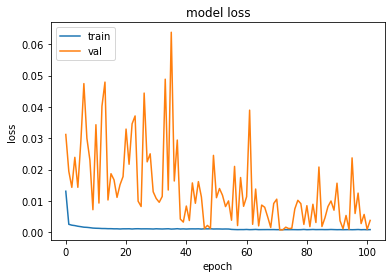

In [174]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper left')
#plt.ylim([0,0.01])
plt.show()
